# CS156 Assignment 1

In [1]:
#importing the needed libraries:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from datetime import date as dt
from sklearn import preprocessing
import seaborn as sn
warnings.filterwarnings("ignore")


# importing the data

In [2]:
#benchmarks_data = pd.read_csv("https://gist.github.com/MoGaber/231a09bf56ff747ee10d8d812da9441c.text")
benchmarks_data = pd.read_csv("benchmarks.txt")

# Cleaning the data

In [3]:
chosen_benchmark_data = benchmarks_data[(benchmarks_data["benchName"]== '471.omnetpp' )] #choosing the benc name
#applying log to the base speed:
chosen_benchmark_data['log(base)'] = chosen_benchmark_data['base'].apply(np.log)

#getting the dates out of the ID:
dates = [] #full date
years = [] #years only

for ID in chosen_benchmark_data["testID"]:
    ID = ID.split('-')[1]
    dates.append(ID[:4] + "-" + ID[4:6]+"-" + ID[6:])
    years.append(ID[:4])

#adding new columns for dates and years:
chosen_benchmark_data['Date'] = dates
chosen_benchmark_data['Years'] = years

# To make it easier, I replace years with numbers from 0 to len(years)
# This should represent how many years passed after the initial time
le = preprocessing.LabelEncoder()
le.fit(list(set(years)))#transforming years to numbers from 0 to...len(years)
chosen_benchmark_data['# Years Passed'] = le.transform(chosen_benchmark_data['Years'])

#transforming dates to ordinal date so that I can plot them:
chosen_benchmark_data['Ordinal Date']=pd.to_datetime(chosen_benchmark_data["Date"]).apply(lambda date: date.toordinal())
chosen_benchmark_data

,testID,benchName,base,peak,log(base),Date,Years,# Years Passed,Ordinal Date
45837,cpu2006-20060513-00001,471.omnetpp,1.03,NaN,0.029559,2006-05-13,2006,0,732444
45866,cpu2006-20060513-00005,471.omnetpp,7.53,NaN,2.018895,2006-05-13,2006,0,732444
45878,cpu2006-20060513-00007,471.omnetpp,7.28,NaN,1.985131,2006-05-13,2006,0,732444
45907,cpu2006-20060513-00010,471.omnetpp,6.76,6.76,1.911023,2006-05-13,2006,0,732444
45953,cpu2006-20060513-00015,471.omnetpp,9.83,NaN,2.285439,2006-05-13,2006,0,732444
...,...,...,...,...,...,...,...,...,...
136876,cpu2006-20120102-19303,471.omnetpp,17.50,18.5,2.862201,2012-01-02,2012,6,734504
136905,cpu2006-20120102-19307,471.omnetpp,23.10,24.3,3.139833,2012-01-02,2012,6,734504
136934,cpu2006-20120102-19311,471.omnetpp,21.80,22.9,3.081910,2012-01-02,2012,6,734504
136963,cpu2006-20120102-19315,471.omnetpp,19.70,20.8,2.980619,2012-01-02,2012,6,734504


# Plotting the data

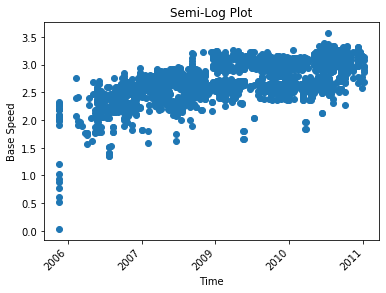

In [4]:
#plotting a semi-log plot:

fig, ax = plt.subplots()
plt.scatter(chosen_benchmark_data['Ordinal Date'], chosen_benchmark_data['log(base)'])

#changing the x axis labels to make it look better:
locs, labels=plt.xticks()
new_xticks=[str(dt.fromordinal(int(item)))[:4] for item in locs]
plt.xticks(locs,new_xticks, rotation=45, horizontalalignment='right')

# scale the size of the graph to the data:
ax.autoscale(enable=True) 

#set labels:
plt.xlabel("Time")
plt.ylabel("Base Speed")
plt.title("Semi-Log Plot")
plt.show()

# Fitting a linear model

In [5]:
# getting the x and y for modeling:
x = np.array(chosen_benchmark_data['# Years Passed']).reshape(-1, 1)
y = np.array(chosen_benchmark_data["log(base)"]).reshape(-1, 1)

# Leaving part of the data out to evaluate the model with:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
#fitting a linear model:
model = linear_model.LinearRegression()
model.fit(x_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [6]:
y_predicted = model.predict(x_test) #predicting x values
r = model.score(x_test,y_test) #calculating R squared 
mse = metrics.mean_squared_error(y_test, y_predicted) #calculating the mean squared error 
print(f"R^2: {r}, MSE: {mse} ")

R^2: 0.3766351797957497, MSE: 0.06615344953122264 


We see from the metrics above the model performs relatively well on the data since MSE is minimized to 0.066

# Evaluating Moor's law

Moore's law says that the speed doubles every two years. This means that $y = c*2^x$ where y is the speed and x is the number of years passed after year 0 and c is the speed at year 0. Since we buit a model to predict log(speed) then Moore's law should be as the following: $log(y) = log(2)x+log(c)$. Our linear model is given as $log(y) = mx+log(c)$. Since x starts at year 0 and increases by only 1 year and Moore's says that speed double every 2 years, then if Moore's law applies to this dataset then we should find that $2*m = log(2)$ which means that the coefficient $m$ of the model should equal $\frac{log(2)}{2} =0.34 $. Let's check that:

In [7]:
print(f"Model Coefficient: {model.coef_}, model intercept: {model.intercept_}")

Model Coefficient: [[0.15342364]], model intercept: [2.25702591]


We see that the coefficient m = 0.1534 which is smaller than what is supposed to be found if Moore's law was true. This means that Moore's law doesn't apply to this dataset. We can make a visualization of this result as the following

In [8]:
#getting the first observation in my data to use it to check Moore's law:
first_observation = np.mean(chosen_benchmark_data[(chosen_benchmark_data['# Years Passed']==0)]["log(base)"])

# the log of the speed according to moore's law: log(y) = log(2)*x + first_observation
Moore_y = [(np.log(2)*X+first_observation) for X in x]

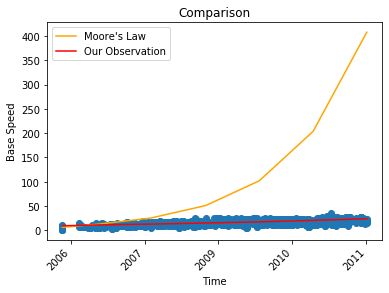

In [9]:
fig, ax = plt.subplots()
plt.scatter(chosen_benchmark_data['Ordinal Date'], chosen_benchmark_data['base'])
locs, labels=plt.xticks()
new_xticks=[str(dt.fromordinal(int(item)))[:4] for item in locs]
new_x = x.copy()
for num, i in enumerate(x):
    new_x[num] = list(chosen_benchmark_data[(chosen_benchmark_data["# Years Passed"] == i[0])]["Ordinal Date"])[0]
    
    
plt.plot(new_x, np.exp(Moore_y), color = 'orange', label = "Moore's Law")
plt.plot(new_x, np.exp(model.predict(x)), color = 'red', label = "Our Observation")
plt.xticks(locs,new_xticks, rotation=45, horizontalalignment='right')
ax.autoscale(enable=True) 
plt.xlabel("Time")
plt.ylabel("Base Speed")
plt.title("Comparison")
plt.legend()
plt.show()

We see from the visualization that the speed is this dataset increases overtime but with a rate way less than what Moore's expected.

# Part 2: MNIST Digits

In [10]:
#loading the dataset:
MNIST_digits_dataset = datasets.load_digits()

# Plotting some examples

<Figure size 432x288 with 0 Axes>

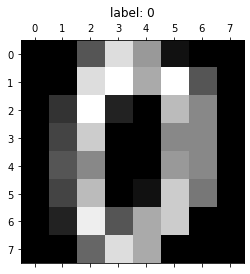

In [11]:
plt.gray()
plt.matshow(MNIST_digits_dataset.images[0])
plt.title(f"label: {MNIST_digits_dataset.target[0]}", y=1.08)
plt.show()

<Figure size 432x288 with 0 Axes>

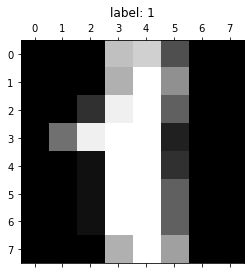

In [12]:
plt.gray()
plt.matshow(MNIST_digits_dataset.images[1])
plt.title(f"label: {MNIST_digits_dataset.target[1]}", y=1.08)
plt.show()

# Choosing zero and three

In [13]:
# making the data for zero:
zero_index = np.where(MNIST_digits_dataset.target == 0)
three_index = np.where(MNIST_digits_dataset.target == 3)
zero_data = MNIST_digits_dataset.data[zero_index] #x
zero_target = MNIST_digits_dataset.target[zero_index] #y

three_data = MNIST_digits_dataset.data[three_index] #x
three_target = MNIST_digits_dataset.target[three_index] #y

#adding the data together to fit the model on them:
model_data = np.concatenate((zero_data, three_data))
model_target = np.concatenate((zero_target, three_target))

# Fitting a model

In [14]:
# holding part of the data out to evaluate the model:
x_train, x_test, y_train, y_test = train_test_split(model_data, model_target, test_size=0.2, random_state=0)

#choosing the best hyperparamters using cross validation:

#making this dictionary of Ks to train the model using each one of them using Cross validation
#and then check which one is better:
tuned_parameter = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

#Running GridSearchCV which uses cross validation of 5 folds to train the model several times with different ks
# and returns the k that has the best performance:
clf = GridSearchCV(
        KNeighborsClassifier(), tuned_parameter, cv=5)

clf.fit(x_train, y_train)
clf.best_params_

{'n_neighbors': 1}

In [15]:
#from above, the best k is k=1
k=1
#fitting a model:
kneigh_model = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)

In [16]:
#evaluating the model:
print(f"The classification accuracy is {(kneigh_model.score(x_test, y_test))*100}%")

The classification accuracy is 100.0%


We see that the accuracy of this model when it runs on the held out data is $100$ which means that the model classified every single digit image in the testing data correclty. This means that we can expect that recall and precision should aslo be $100$ :

In [17]:
print(metrics.classification_report(y_test, kneigh_model.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           3       1.00      1.00      1.00        37

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73



In [18]:
confus_matrix = metrics.confusion_matrix(y_test, kneigh_model.predict(x_test))

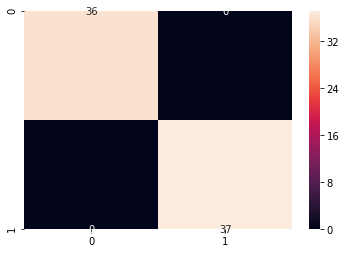

In [19]:
sn.heatmap(confus_matrix, annot=True)

# Fitting the model using data of all digits

In [20]:
model_data = MNIST_digits_dataset.data #x
model_target = MNIST_digits_dataset.target #y

In [21]:
x_train, x_test, y_train, y_test = train_test_split(model_data, model_target, test_size=0.2, random_state=0)
kneigh_model = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)

In [22]:
print(metrics.classification_report(y_test, kneigh_model.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        35
           2       1.00      0.97      0.99        36
           3       0.94      1.00      0.97        29
           4       1.00      1.00      1.00        30
           5       0.97      0.97      0.97        40
           6       1.00      1.00      1.00        44
           7       1.00      1.00      1.00        39
           8       1.00      1.00      1.00        39
           9       0.97      0.95      0.96        41

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



In [23]:
confus_matrix = metrics.confusion_matrix(y_test, kneigh_model.predict(x_test))

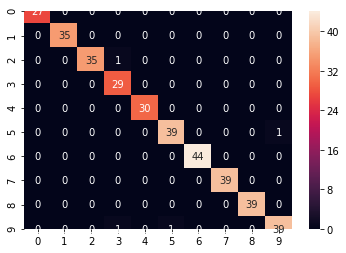

In [24]:
sn.heatmap(confus_matrix, annot=True)